<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/simple_fft_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import plot_model

In [3]:
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
dataset_size = 10000
load_models = False # Loading previously saved model. Retraining models if false.
auto_scale = False # Whether or not to automatically scale the number of kernels to the number of outputs. If False, 2 convolutional kernels are used.

In [6]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/'

In [7]:
def makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs):
  model = Sequential()
  #model.add(tf.keras.layers.experimental.preprocessing.Normalization()) # Comment out if no normalization of input data
  model.add(Conv1D(no_kernels, length_kernel, activation='relu', padding='same', input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(no_outputs, activation='linear'))
  return model

In [8]:
def plothistory(history):
  plt.figure(figsize=(16,10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.grid(which='both')
  plt.show()

In [9]:
def compile_and_train(X_train, y_train, filename, no_kernels=2,):
  length_kernel = 32
  no_outputs = y_train.shape[1]
  input_shape = (X_train.shape[1], X_train.shape[2]) # Only one trace per sample
  model = makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs)
  #plot_model(model, show_shapes=True, show_layer_names=True)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)
  plothistory(history)
  print(model.summary())
  model.save(filename)
  return model


In [10]:
def getmodel(X_train, y_train, filename, loadmodel=False, autoscale=True):
  if loadmodel:
    model = load_model(filename)
    print('Model loaded: ' + filename)
  else:
    if autoscale:
      no_kernels = y_train.shape[1]
    else:
      no_kernels = 2
    model = compile_and_train(X_train, y_train, filename, no_kernels=no_kernels)
    

  return model

In [11]:
def makecwsignal(amp, freq, phase, samplingfreq=128, t_end=1):
  # Returns CW cosine signal based on input parameters
  dt = 1/samplingfreq
  t_array = np.arange(0, t_end, dt)
  y = amp*np.cos(2*np.pi*freq*t_array + phase)
  return y

In [12]:
def makerandom(n, source_central_freq=10, source_mag = 1, seed=42):
  ''' Returns random frequencies around central frequency, random phase and 
  random amplitude. Random phase between 0 and pi.
  '''
  rng = np.random.default_rng(seed)
  randfreqs = source_central_freq*(0.5+rng.random(n))
  #randphases = 2*np.pi*rng.random(n) #if multiplied with 2, between 0 and 2pi
  randphases = rng.uniform(low=1, high=2*np.pi-1, size=n) #Phase between 1 and 5.28
  randamps = source_mag*(0.5+rng.random(n))
  d = {'Amplitude': randamps, 'Frequency': randfreqs, 'Phase': randphases}
  return pd.DataFrame(data=d)

In [13]:
def plot_hists(df):
  numplots = len(df.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(df.columns):
    plt.subplot(1,numplots, i+1)
    plt.hist(df[attribute])
    plt.title(attribute)

In [14]:
def preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  df_traces = pd.DataFrame(traces)
  plt.plot(traces[0])
  plt.plot(traces[1])
  plt.show()
  plt.figure(figsize=(18, 10))
  plt.pcolormesh(df_traces.T)
  plt.gca().invert_yaxis()
  plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(df_traces, df_iterations, test_size=0.2, random_state=42)
  X_train = np.expand_dims(X_train, axis=2)
  X_train.shape, y_train.shape
  return X_train, X_test, y_train, y_test

In [15]:
def test_and_predict(model, X_test, y_test):
  if X_test.ndim < 3:
    X_test = np.expand_dims(X_test, axis=2)
  performance = model.evaluate(X_test, y_test)
  y_predict = model(X_test)
  df_y_predict = pd.DataFrame(y_predict.numpy(), columns=y_test.columns)
  return df_y_predict, performance


In [16]:
def plotprediction(data_truth, data_prediction):
  numplots = len(data_prediction.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(data_prediction.columns):
    plt.subplot(1,numplots, i+1)
    plt.scatter(data_truth[attribute], data_prediction[attribute])
    plt.plot([min(data_truth[attribute]), max(data_truth[attribute])], [min(data_truth[attribute]), max(data_truth[attribute])], 'r--' )
    plt.title('Predicted vs true ' + attribute)
    plt.grid(which='both')
  plt.show()

In [17]:
def scale_features(df_iterations): 
  # Features min-max scaling
  scaler = MinMaxScaler()
  scaler.fit(df_iterations)
  df_iterations_norm = pd.DataFrame(scaler.transform(df_iterations), columns=df_iterations.columns)
  return df_iterations_norm, scaler

In [18]:
def inverse_scale_features(df_iterations_norm, scaler):
  return pd.DataFrame(scaler.inverse_transform(df_iterations_norm), columns=df_iterations_norm.columns)

In [19]:
#Amplitudes for CW2 always lower than for CW1
df_iterations_cw1 = makerandom(dataset_size, source_central_freq=10, source_mag=2, seed=11)
df_iterations_cw2 = makerandom(dataset_size, source_central_freq=10, source_mag=0.5, seed=22)
df_iterations_cw1.rename(columns={'Amplitude': 'Amplitude_1', 'Frequency': 'Frequency_1', 'Phase': 'Phase_1'}, inplace=True)
df_iterations_cw2.rename(columns={'Amplitude': 'Amplitude_2', 'Frequency': 'Frequency_2', 'Phase': 'Phase_2'}, inplace=True)


In [20]:
cw1 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw1['Amplitude_1'], df_iterations_cw1['Frequency_1'], df_iterations_cw1['Phase_1'])]
cw2 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw2['Amplitude_2'], df_iterations_cw2['Frequency_2'], df_iterations_cw2['Phase_2'])]


In [21]:
df_iterations_cw1_norm, scaler = scale_features(df_iterations_cw1)

In [22]:
def make_fft(traces):
  sample_rate = 128
  duration = 1
  n = sample_rate * duration
  traces_fft = rfft(traces, n=256)
  amps = np.abs(traces_fft)
  angles = np.angle(traces_fft)
  xf = rfftfreq(2*n, 1/sample_rate)
  return xf[0:-1], np.stack((traces, amps[:,0:-1], angles[:,0:-1]), axis=-1)

In [23]:
def train_and_test(traces, df_iterations, modelname, loadmodels=False, dataset_size=10000, no_kernels=2, length_kernel=32, use_trace=True, use_ampspect=True, use_phasespect=True):
  print(dataset_size)
  traces = traces[:dataset_size]
  df_iterations = df_iterations[:dataset_size]
  xf, traces_fft = make_fft(traces)
  if use_trace and not use_ampspect and not use_phasespect:
    traces_stacked = traces_fft[:,:,0]
    traces_stacked = np.expand_dims(traces_stacked, axis=-1)
  elif use_trace and use_ampspect and not use_phasespect:
    traces_stacked = traces_fft[:,:,0:2]
  elif use_trace and use_ampspect and use_phasespect:
    traces_stacked = traces_fft
  elif not use_trace and use_ampspect and not use_phasespect:
    traces_stacked = traces_fft[:,:,1]
    traces_stacked = np.expand_dims(traces_stacked, axis=-1)
  elif not use_trace and use_ampspect and use_phasespect:
    traces_stacked = traces_fft[:,:,1:3]
  else:
    print('error')
  
  df_iterations_norm, scaler = scale_features(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(traces_stacked, df_iterations_norm, test_size=0.2, random_state=42)
  print(X_train.shape)
  input_shape = X_train[0].shape
  print(input_shape)
  if loadmodels:
    print('Loading model: '+ path+modelname)
    model = load_model(path+modelname)
  else:
    model = makecnnmodel(input_shape=input_shape, no_kernels=no_kernels, length_kernel=length_kernel, no_outputs=3)
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=0, validation_split=0.2, shuffle=True)
    model.save(path+modelname)

  df_y_predict, performance = test_and_predict(model, X_test, y_test)

  y_test_unscaled = inverse_scale_features(y_test, scaler)
  df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler)
  plotprediction(y_test_unscaled, df_y_predict_unscaled)
  return pd.DataFrame([performance], columns=['loss', 'mse', 'mae'])

In [24]:
functionargs = list()

In [25]:

functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})

functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})

functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})

functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})

functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})

functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 10000, 'no_kernels': 2, 'length_kernel': 2, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})


In [26]:
functionargs[0]

{'dataset_size': 1000,
 'length_kernel': 32,
 'no_kernels': 2,
 'use_ampspect': False,
 'use_phasespect': False,
 'use_trace': True}

In [27]:
len(functionargs)

30

0
00_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_False_use_phasespect_False
1000
(800, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/00_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_False_use_phasespect_False/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0304


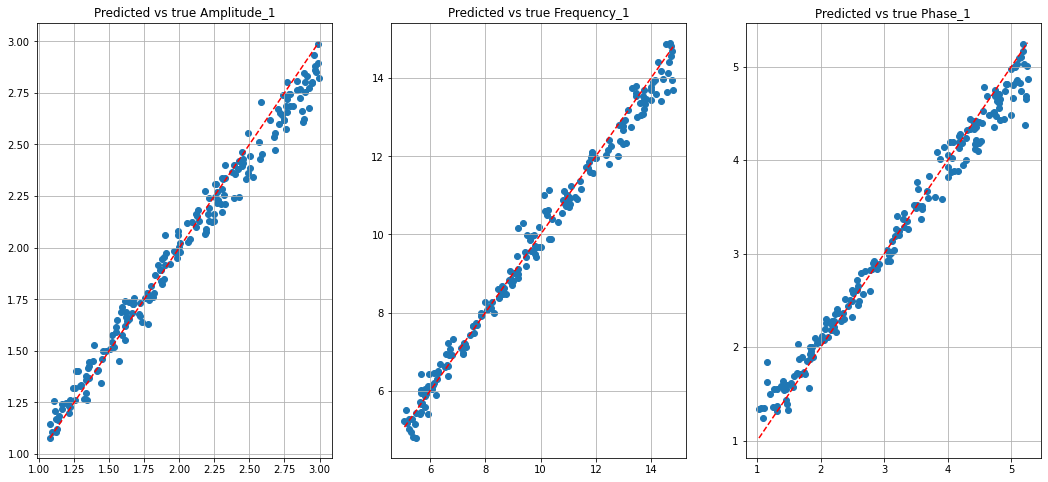

1
01_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_False
1000
(800, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/01_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_False/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1021


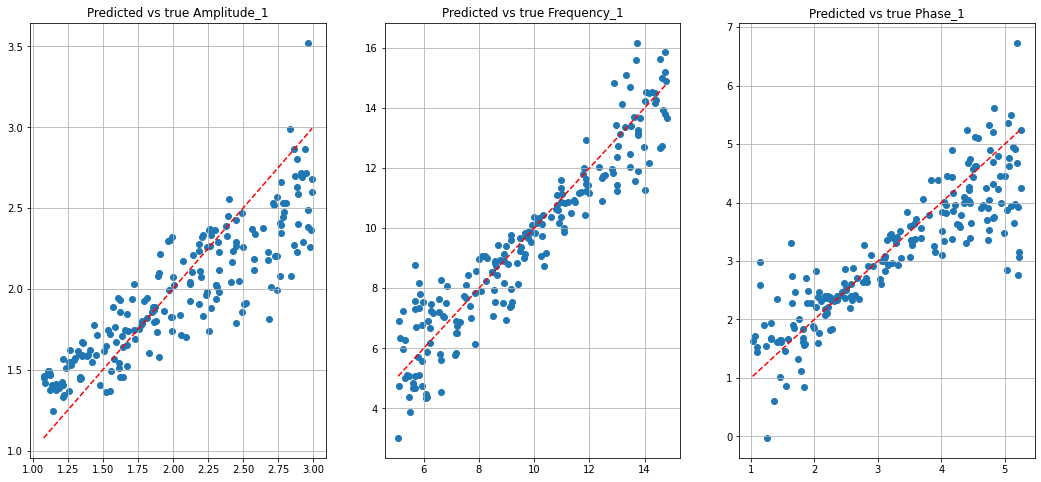

2
02_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_True
1000
(800, 128, 3)
(128, 3)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/02_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_True/assets
7/7 [==============================] - 0s 3ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0957


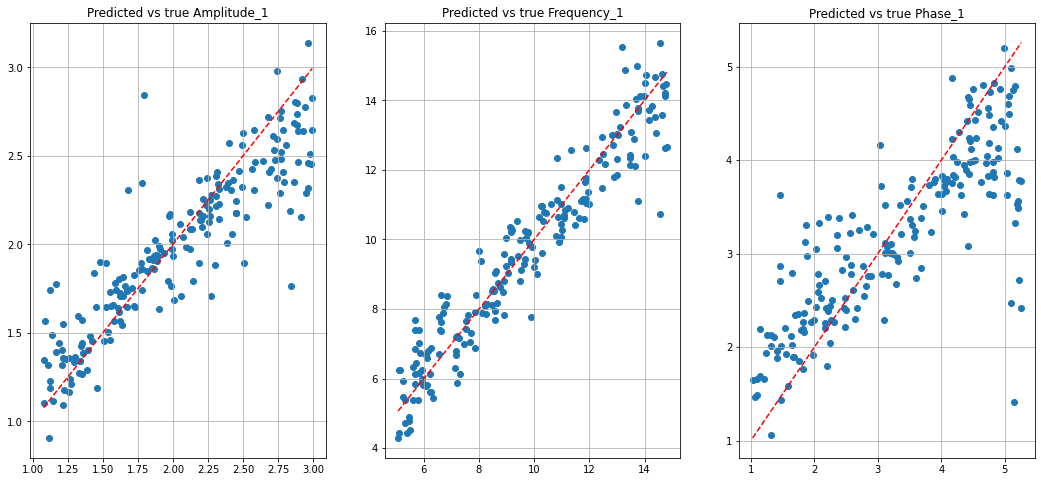

3
03_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_False
1000
(800, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/03_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_False/assets
7/7 [==============================] - 0s 3ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1642


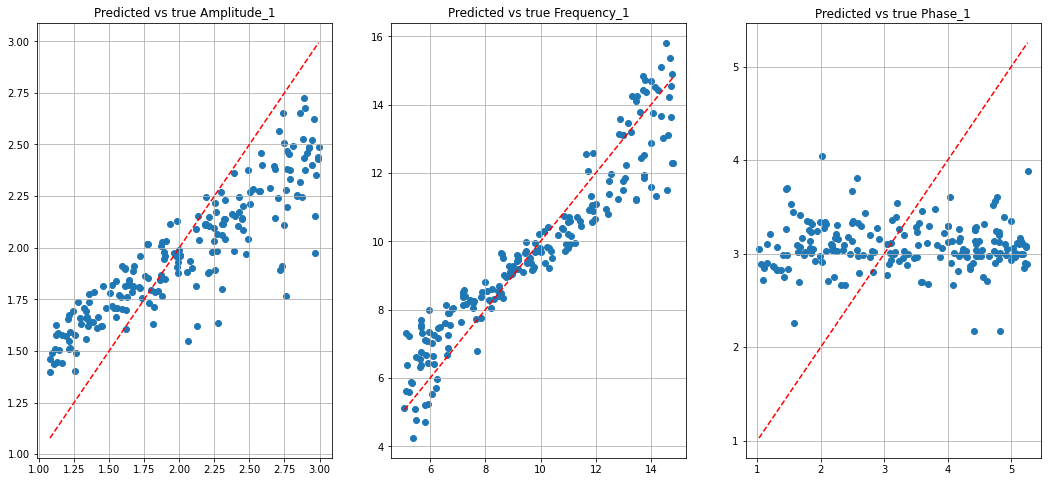

4
04_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_True
1000
(800, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/04_dataset_size_1000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_True/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1514


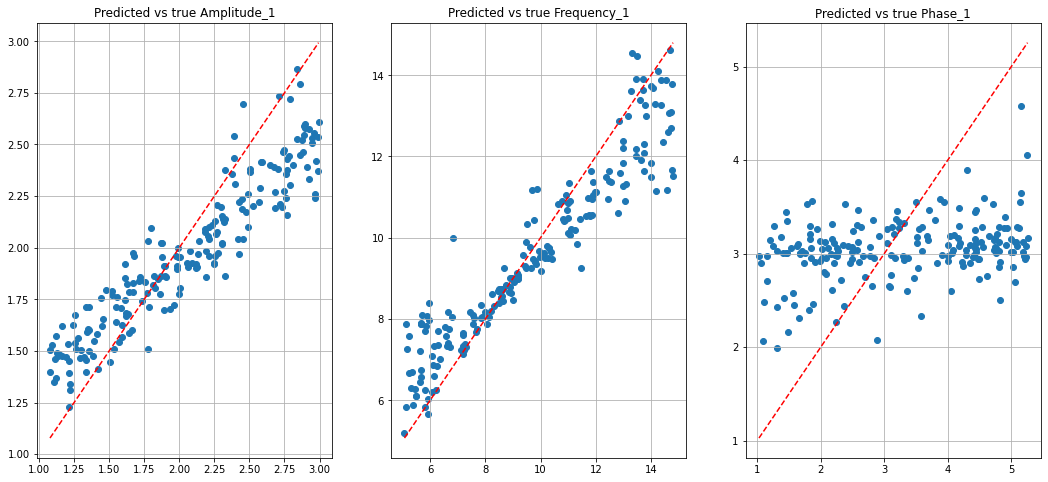

5
05_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_False_use_phasespect_False
1000
(800, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/05_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_False_use_phasespect_False/assets
7/7 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0446


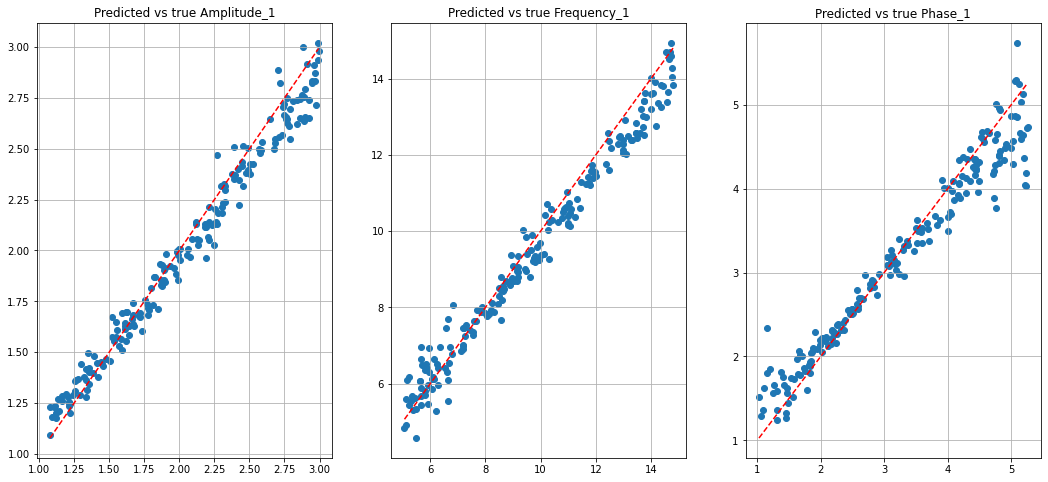

6
06_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_False
1000
(800, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/06_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_False/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0677


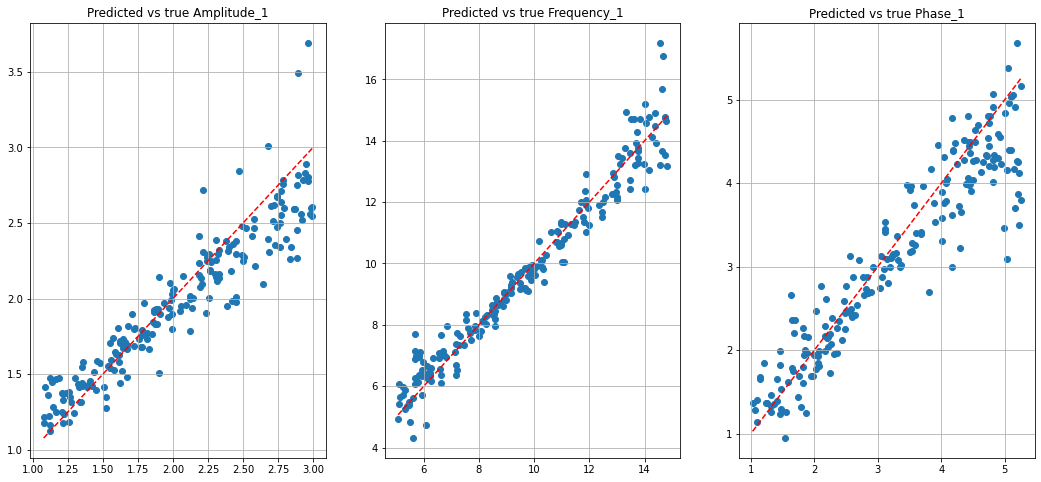

7
07_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_True
1000
(800, 128, 3)
(128, 3)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/07_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_True/assets
7/7 [==============================] - 0s 5ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1079


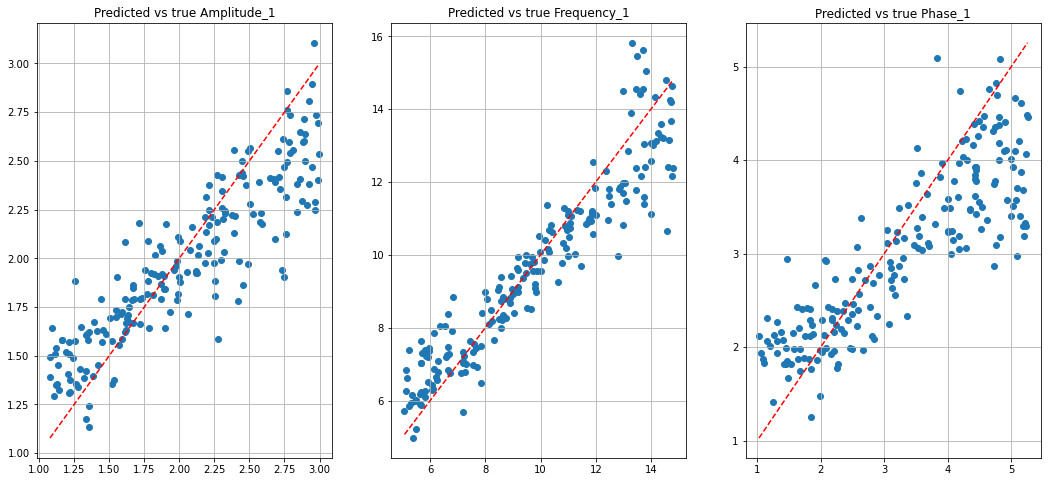

8
08_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_False
1000
(800, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/08_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_False/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1421


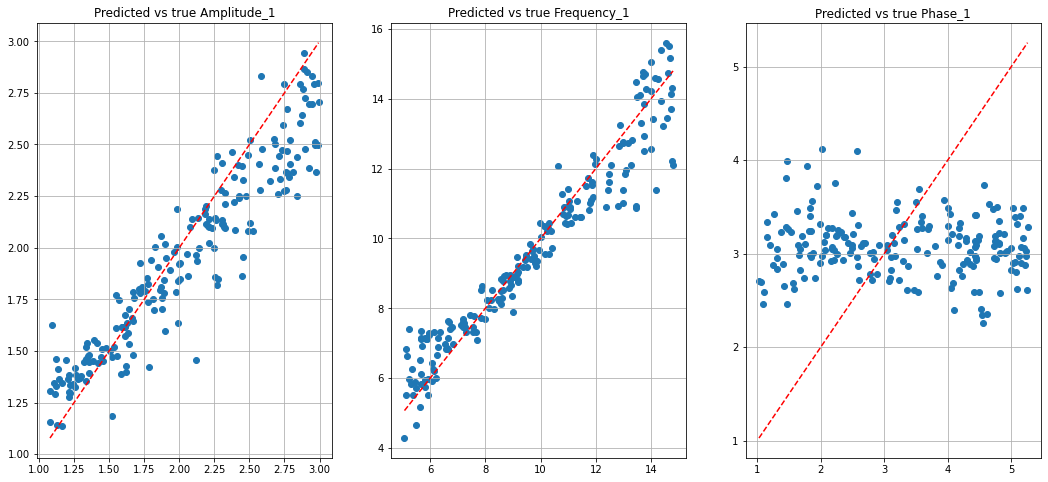

9
09_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_True
1000
(800, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/09_dataset_size_1000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_True/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.1015


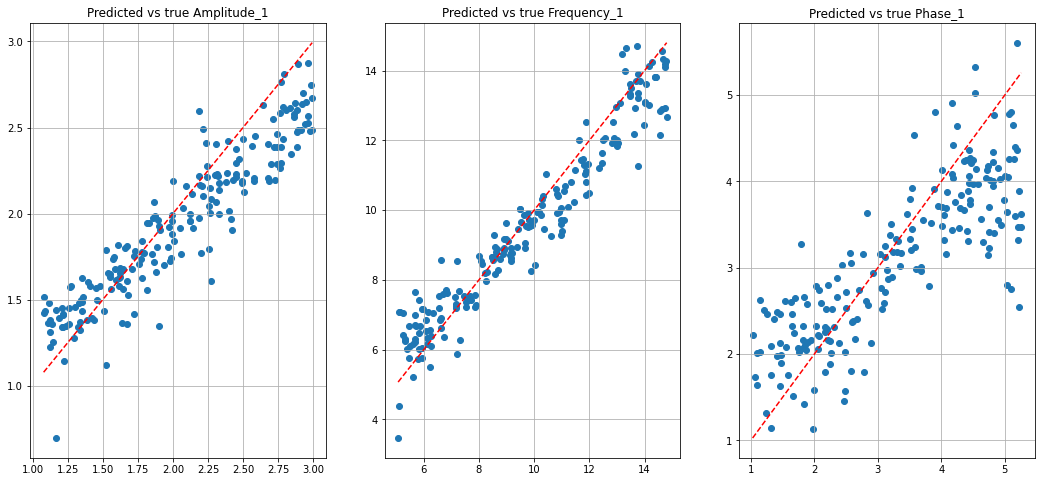

10
10_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_False_use_phasespect_False
1000
(800, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/10_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_False_use_phasespect_False/assets
7/7 [==============================] - 0s 5ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0332


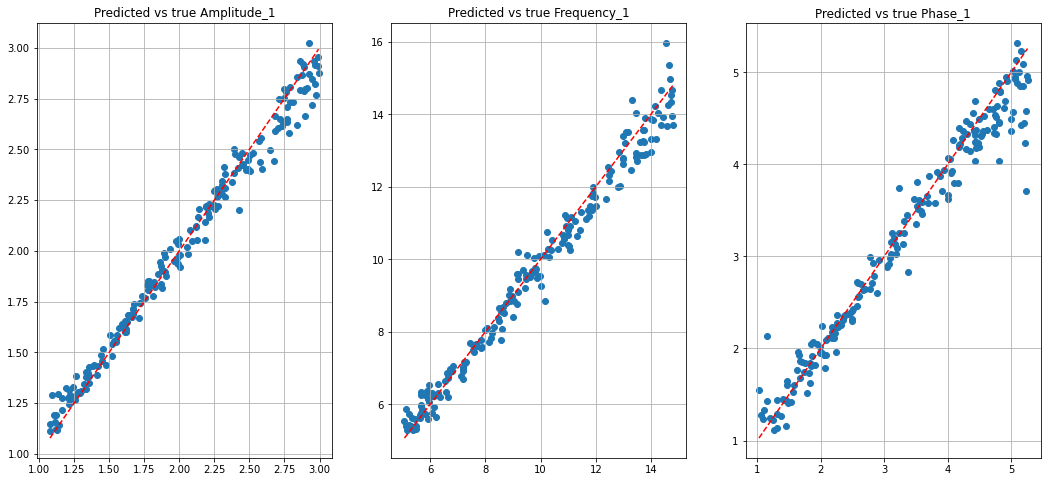

11
11_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_False
1000
(800, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/11_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_False/assets
7/7 [==============================] - 0s 5ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0785


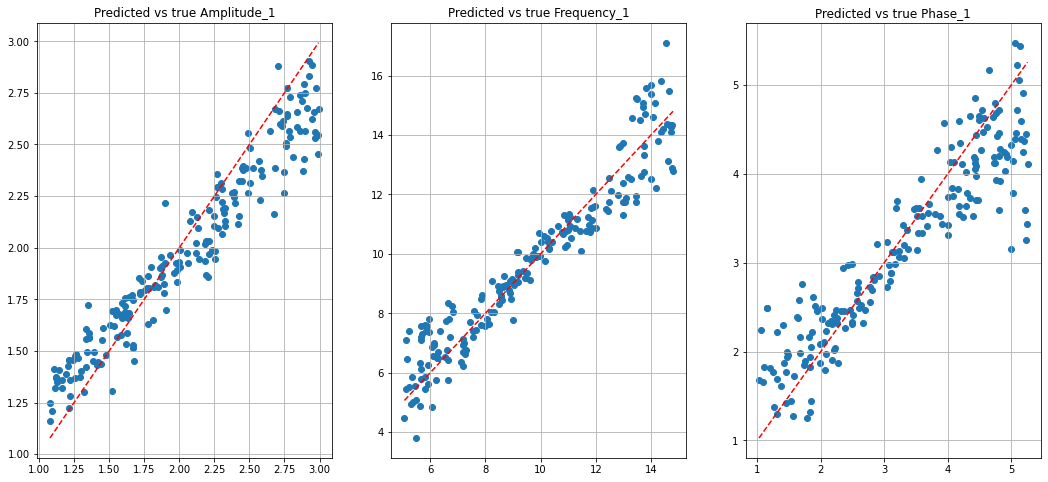

12
12_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_True
1000
(800, 128, 3)
(128, 3)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/12_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_True/assets
7/7 [==============================] - 0s 5ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0926


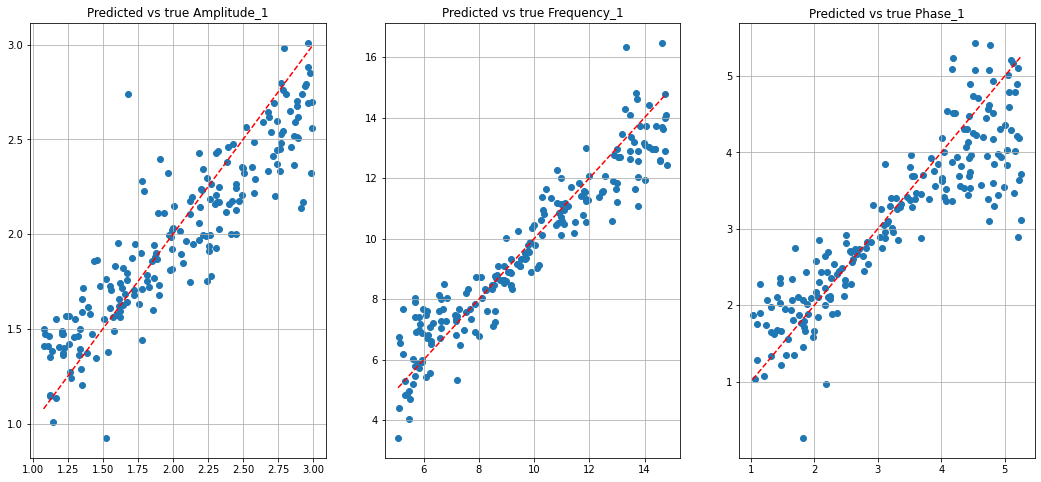

13
13_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_False
1000
(800, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/13_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_False/assets
7/7 [==============================] - 0s 4ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1700


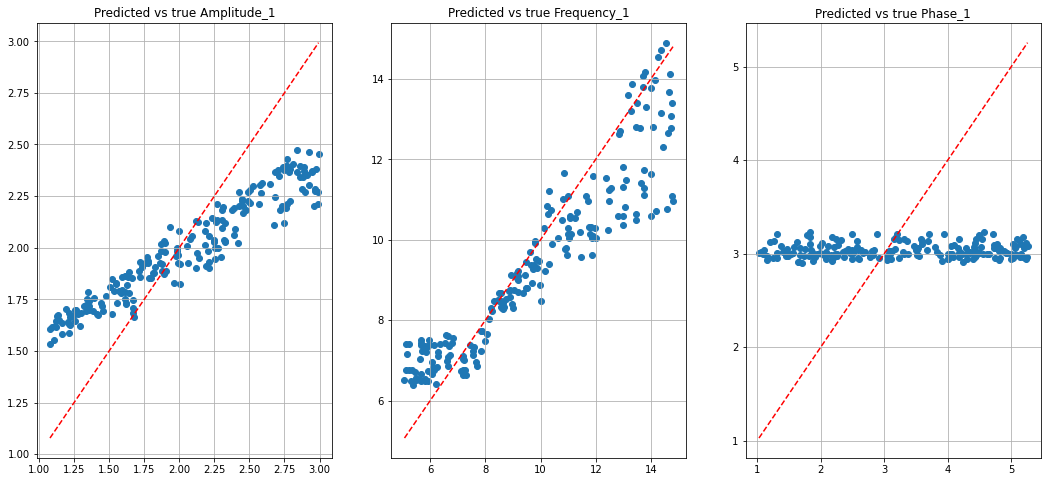

14
14_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_True
1000
(800, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/14_dataset_size_1000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_True/assets
7/7 [==============================] - 0s 8ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1055


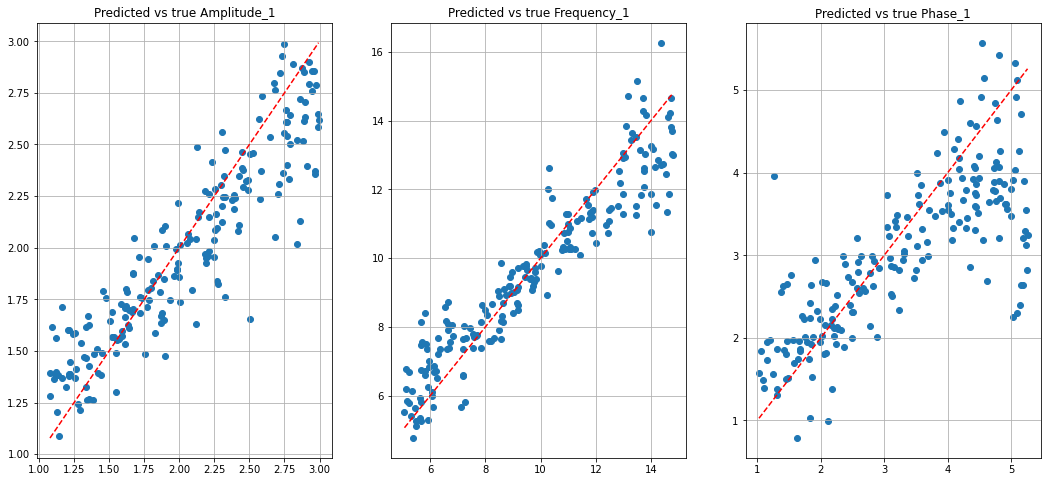

15
15_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_False_use_phasespect_False
10000
(8000, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/15_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_False_use_phasespect_False/assets
63/63 [==============================] - 1s 4ms/step - loss: 3.1582e-04 - mse: 3.1582e-04 - mae: 0.0133


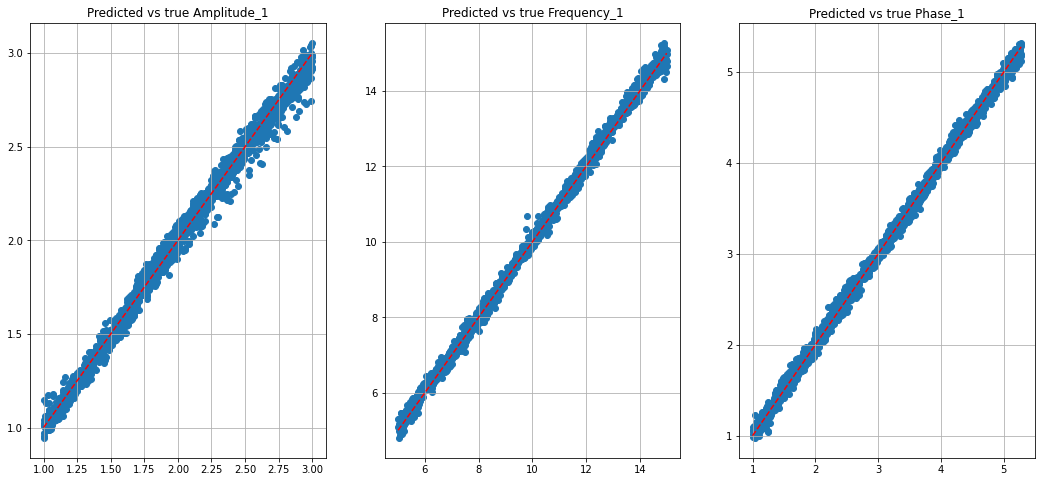

16
16_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_False
10000
(8000, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/16_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_False/assets
63/63 [==============================] - 1s 4ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0255


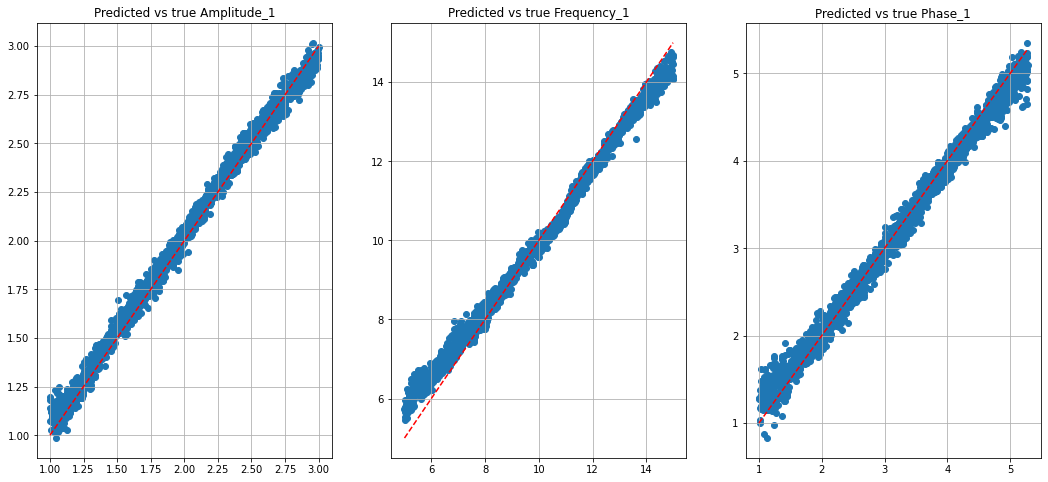

17
17_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_True
10000
(8000, 128, 3)
(128, 3)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/17_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_True_use_ampspect_True_use_phasespect_True/assets
63/63 [==============================] - 1s 3ms/step - loss: 7.0734e-04 - mse: 7.0734e-04 - mae: 0.0203


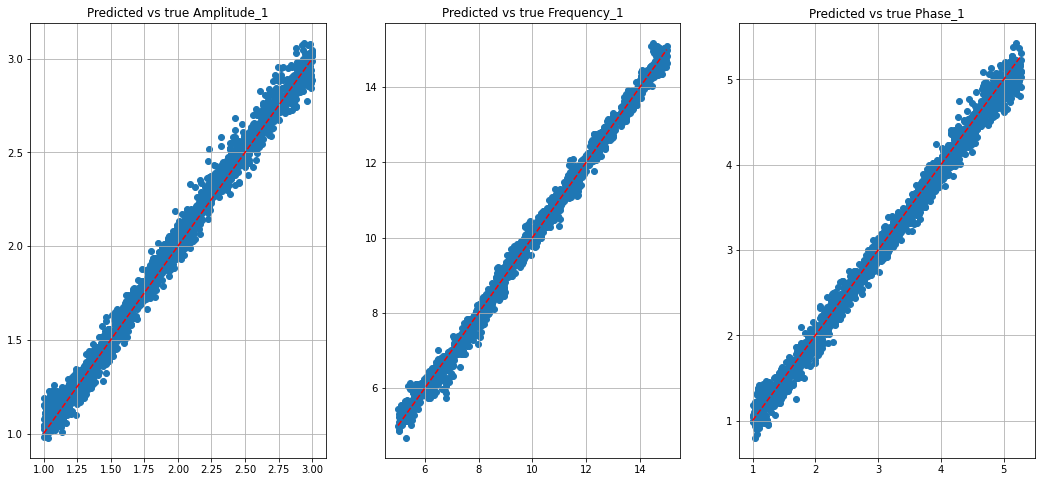

18
18_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_False
10000
(8000, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/18_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.0958


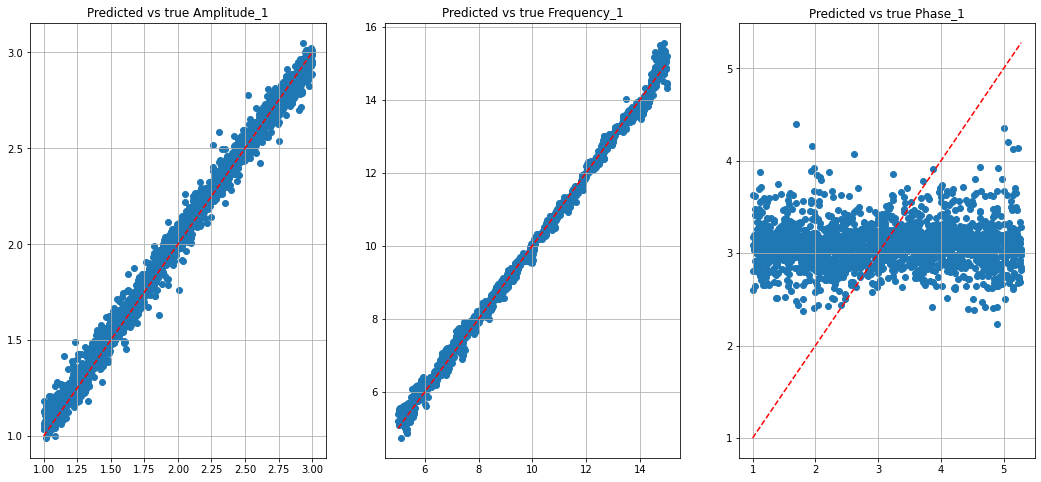

19
19_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_True
10000
(8000, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/19_dataset_size_10000_no_kernels_2_length_kernel_32_use_trace_False_use_ampspect_True_use_phasespect_True/assets
63/63 [==============================] - 1s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0271


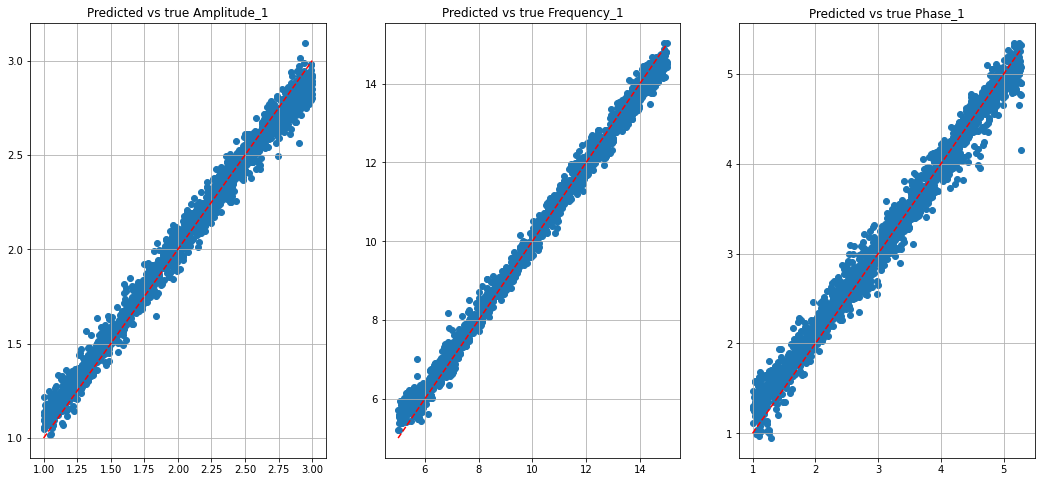

20
20_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_False_use_phasespect_False
10000
(8000, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/20_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_False_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 4.1709e-04 - mse: 4.1709e-04 - mae: 0.0154


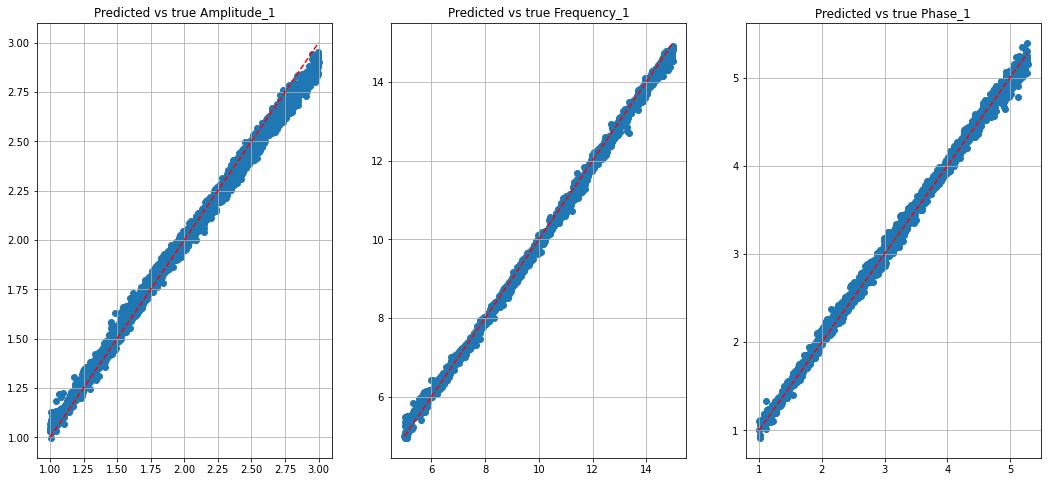

21
21_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_False
10000
(8000, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/21_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 4.9998e-04 - mse: 4.9998e-04 - mae: 0.0174


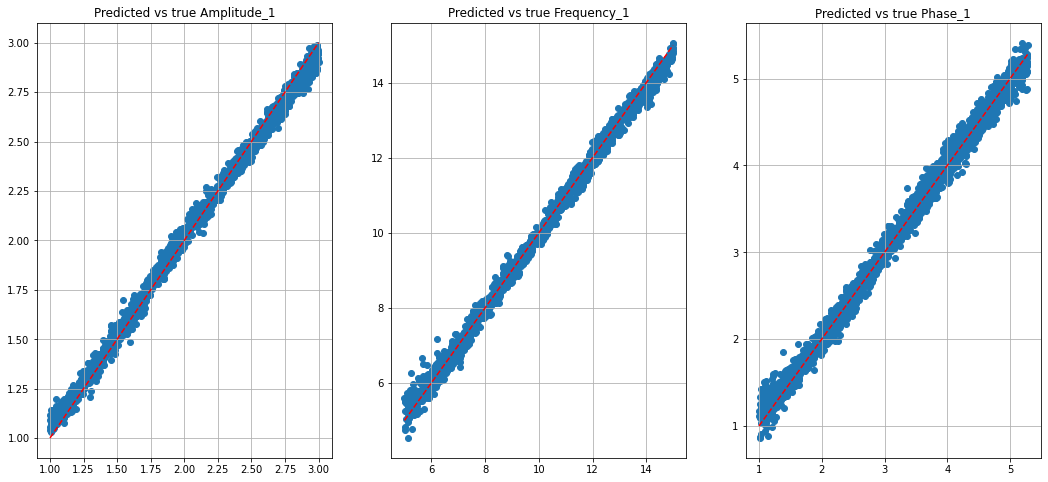

22
22_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_True
10000
(8000, 128, 3)
(128, 3)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/22_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_True_use_ampspect_True_use_phasespect_True/assets
63/63 [==============================] - 1s 3ms/step - loss: 8.4962e-04 - mse: 8.4962e-04 - mae: 0.0229


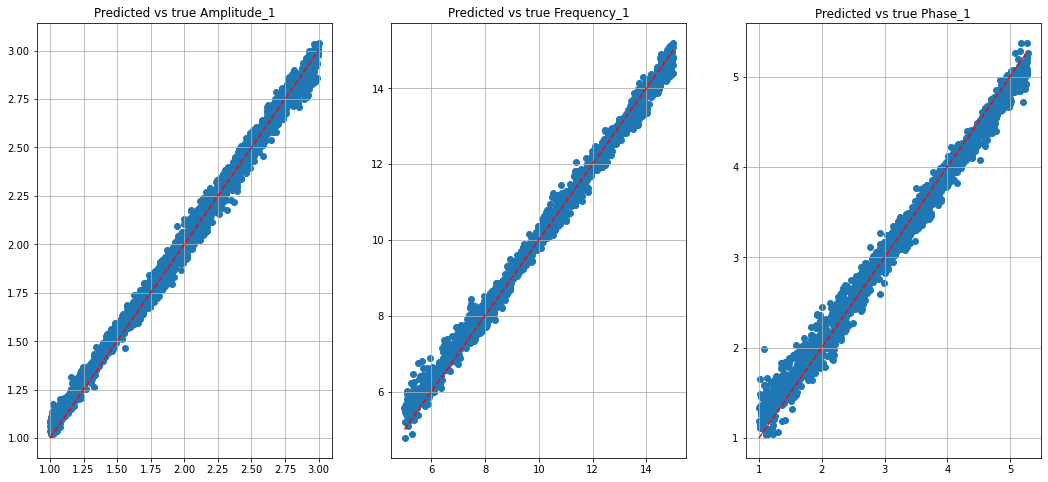

23
23_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_False
10000
(8000, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/23_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.0961


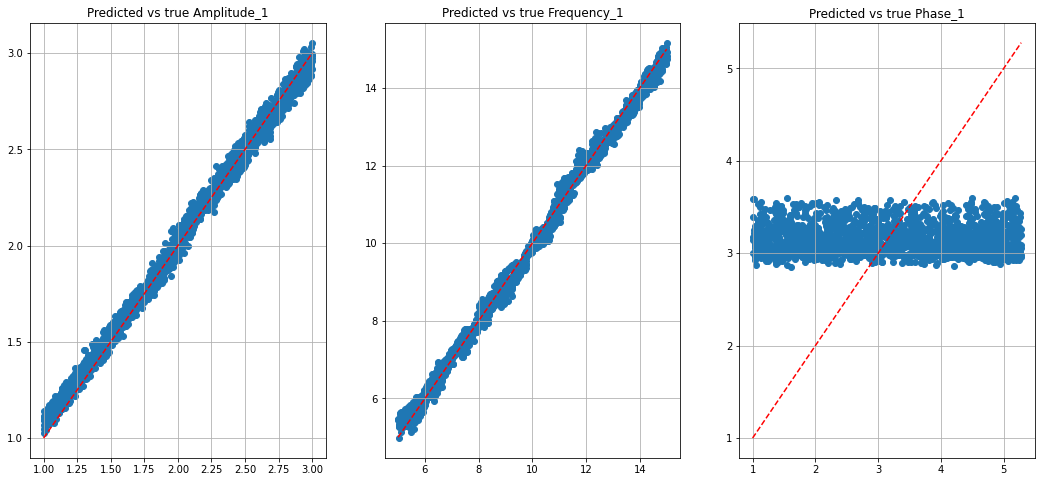

24
24_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_True
10000
(8000, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/24_dataset_size_10000_no_kernels_2_length_kernel_8_use_trace_False_use_ampspect_True_use_phasespect_True/assets
63/63 [==============================] - 1s 4ms/step - loss: 9.2449e-04 - mse: 9.2449e-04 - mae: 0.0223


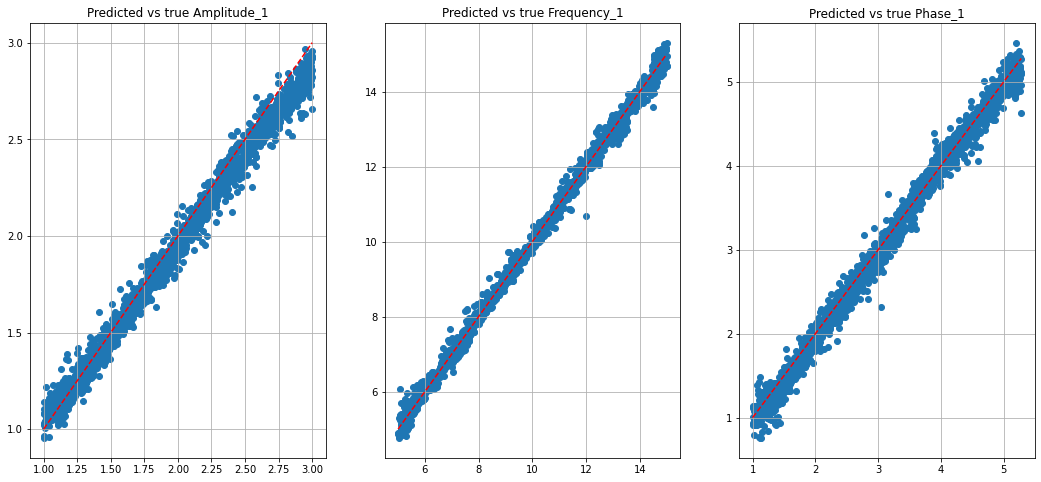

25
25_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_False_use_phasespect_False
10000
(8000, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/25_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_False_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 2.5108e-04 - mse: 2.5108e-04 - mae: 0.0126


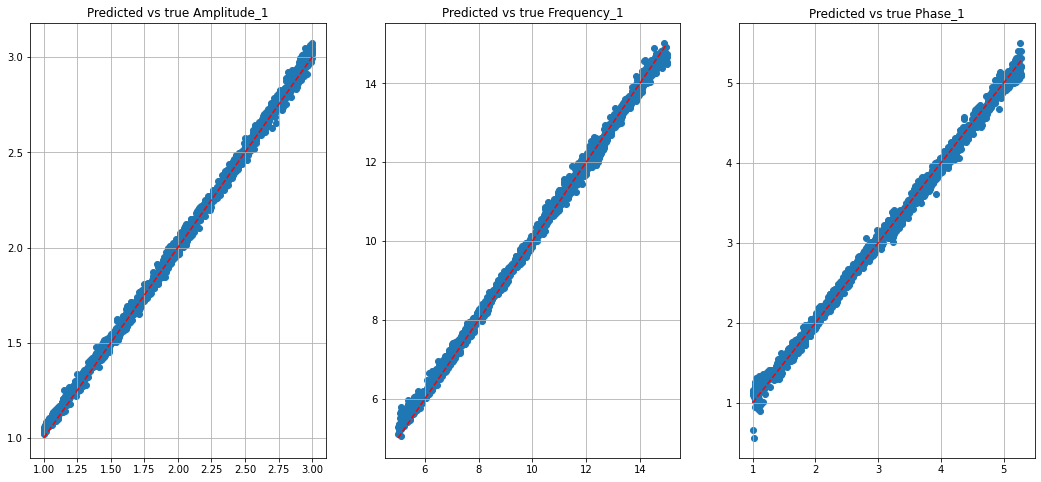

26
26_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_False
10000
(8000, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/26_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 6.9414e-04 - mse: 6.9414e-04 - mae: 0.0207


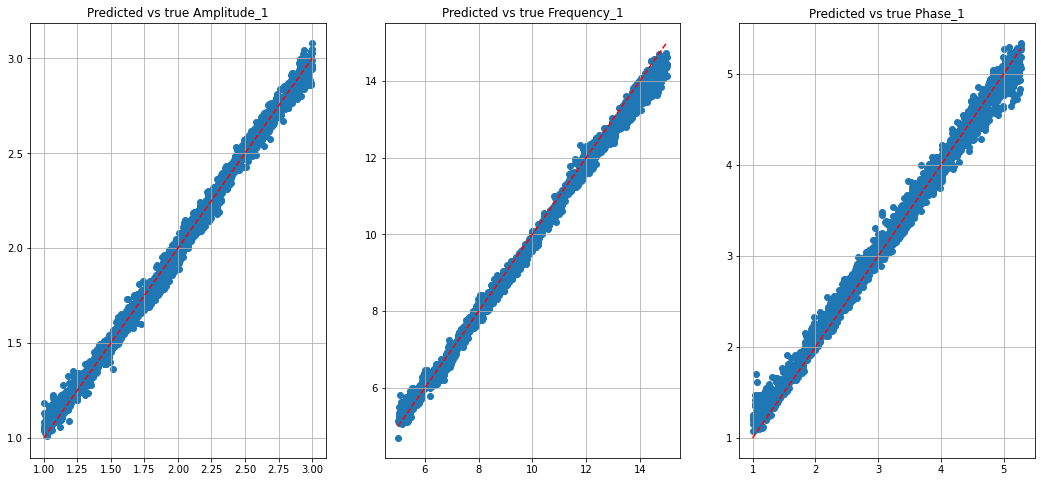

27
27_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_True
10000
(8000, 128, 3)
(128, 3)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/27_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_True_use_ampspect_True_use_phasespect_True/assets
63/63 [==============================] - 1s 3ms/step - loss: 0.0571 - mse: 0.0571 - mae: 0.1912


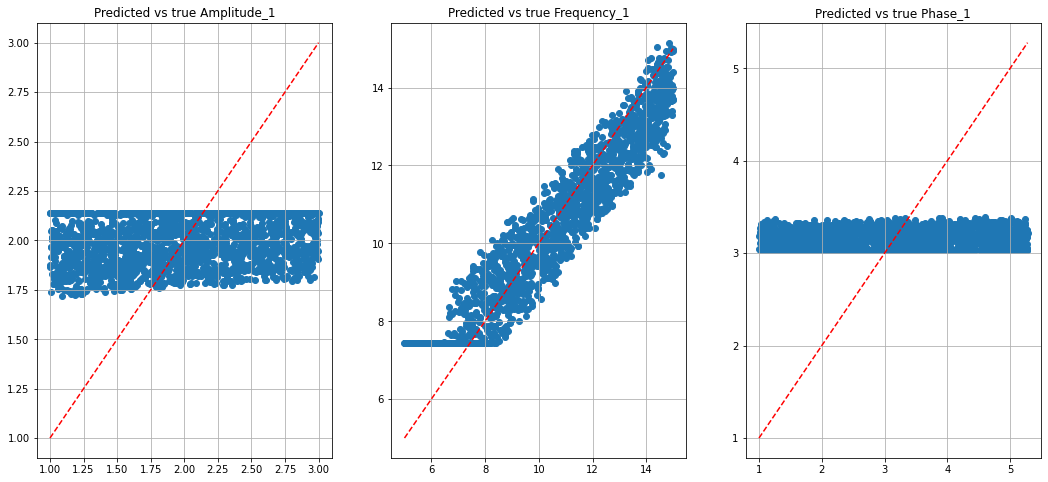

28
28_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_False
10000
(8000, 128, 1)
(128, 1)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/28_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_False/assets
63/63 [==============================] - 1s 3ms/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1014


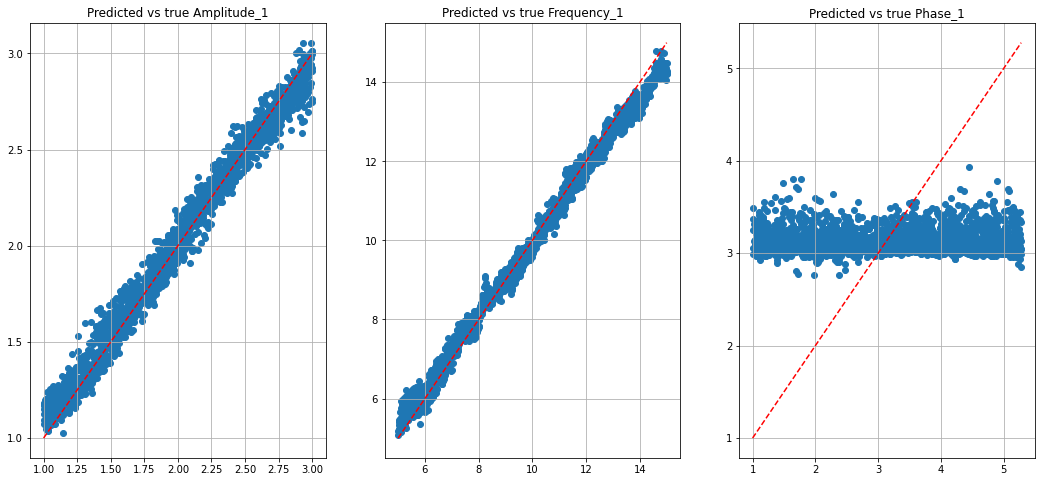

29
29_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_True
10000
(8000, 128, 2)
(128, 2)
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_simple_fft_test/29_dataset_size_10000_no_kernels_2_length_kernel_2_use_trace_False_use_ampspect_True_use_phasespect_True/assets
63/63 [==============================] - 1s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0286


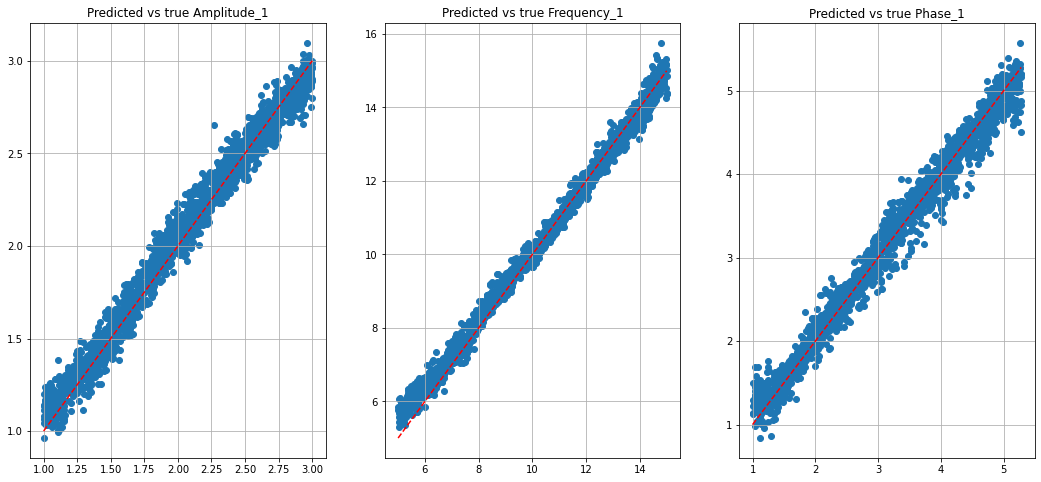

In [28]:
for i in range(len(functionargs)):
  modelname = '{:0>2}'.format(i) + '_' + '_'.join(['{0}_{1}'.format(key, value) for (key, value) in functionargs[i].items()])
  print(i)
  print(modelname)
  df_performance = train_and_test(cw1, df_iterations_cw1, modelname, loadmodels=False, **functionargs[i])
  if i==0:
    df_functionargs = pd.DataFrame.from_dict([functionargs[i]]).join(df_performance)
  else:
    df_functionargs = df_functionargs.append((pd.DataFrame.from_dict([functionargs[i]])).join(df_performance), ignore_index=True)

In [29]:
df_functionargs

,dataset_size,no_kernels,length_kernel,use_trace,use_ampspect,use_phasespect,loss,mse,mae
0,1000,2,32,True,False,False,0.001655,0.001655,0.030399
1,1000,2,32,True,True,False,0.018463,0.018463,0.102081
2,1000,2,32,True,True,True,0.018840,0.018840,0.095684
3,1000,2,32,False,True,False,0.044984,0.044984,0.164236
4,1000,2,32,False,True,True,0.039118,0.039118,0.151383
5,1000,2,8,True,False,False,0.003583,0.003583,0.044600
6,1000,2,8,True,True,False,0.009145,0.009145,0.067738
7,1000,2,8,True,True,True,0.020219,0.020219,0.107911
8,1000,2,8,False,True,False,0.040576,0.040576,0.142093
9,1000,2,8,False,True,True,0.018084,0.018084,0.101530


In [30]:
df_functionargs.sort_values(by=['loss'])

,dataset_size,no_kernels,length_kernel,use_trace,use_ampspect,use_phasespect,loss,mse,mae
25,10000,2,2,True,False,False,0.000251,0.000251,0.012611
15,10000,2,32,True,False,False,0.000316,0.000316,0.013324
20,10000,2,8,True,False,False,0.000417,0.000417,0.015395
21,10000,2,8,True,True,False,0.000500,0.000500,0.017427
26,10000,2,2,True,True,False,0.000694,0.000694,0.020728
17,10000,2,32,True,True,True,0.000707,0.000707,0.020334
22,10000,2,8,True,True,True,0.000850,0.000850,0.022876
24,10000,2,8,False,True,True,0.000924,0.000924,0.022304
16,10000,2,32,True,True,False,0.001069,0.001069,0.025523
19,10000,2,32,False,True,True,0.001219,0.001219,0.027062
